TODO:
Divide into strips w/ grand staff
Calculate median pixel value in each row (close to 0, then very high etc)
Use this row median graph, cut into indivdiual staffs, then go into coord system by mapping vertical position to one note (e.g. right goes C4 to B6),
left goes from C2 to B3

How can we est the location of the 5 peaks + do linear interp? Lowest peak = E4, then G4, then B4, D5, F5.

Touch base with Mint so she can point to appropriate code and you can try using it after fixing the graph  to log. 

Use code Mint points you to in order to find a way to convert each score into individual staff lines (e.g. just RH, just LH), calculate median of each row, est location of 5 peaks, then do linear interpolation w/ built-in SKLearn/Numpy to d o a linear interp of the 5 

Give  it pairs of x,y coords. So like notes 0,2,4,6,8, ... up to 20 so 21-dim vector. y-axis is which note out of 21, then x-axis is the vertical pixel position from the bottom (e.g. 35 pixels until then)--use lin interp to convert from vertical pixel position to discretized note value. Then can do a look up in a hash table or smth. 

1. Pull out individual strips from a page of sheet music
2. Mint's intial code for above things--try to est conversion from vertical pixel position to discretized note value. 

In [1]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy import ndimage
from scipy import signal
from scipy.stats import linregress
from scipy.signal import convolve2d, gaussian, argrelextrema
from scipy.interpolate import interp1d
from sklearn.preprocessing import normalize
from skimage.transform import rotate
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle as cPickle
import librosa
import glob
import re
import sys
import os
import mido
from mido import MidiFile
import cv2
from PIL import Image

In [2]:
test_image = Image.open(os.path.join("prepped_png_danielcopy", "bwv871_vfinale", "bwv871_vfinale-2.png")).convert('L')

In [3]:
img_array = np.array(test_image)

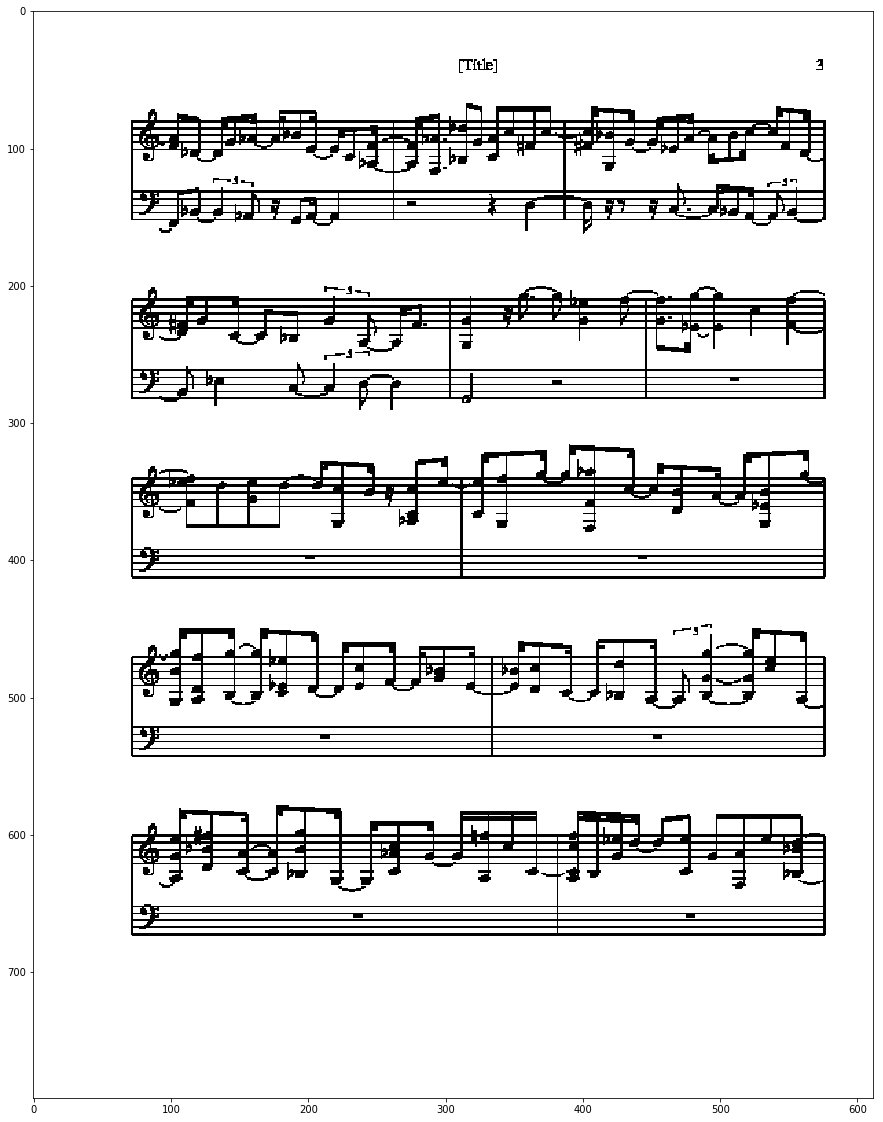

In [4]:
plt.figure(figsize=(20,20))
plt.imshow(img_array, cmap="gray")

# Actual Things

In [8]:
test_png = os.path.join("prepped_png_danielcopy", "bwv871_vfinale", "bwv871_vfinale-2.png")

In [5]:
def importImage(pngfile):
    img = ndimage.imread(pngfile, flatten=True)
    img = 1 - img/255.0 # make white -> 0, black -> 1
    return img

In [6]:
def showImage(X, sz = (12,12)):
    plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray')

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app


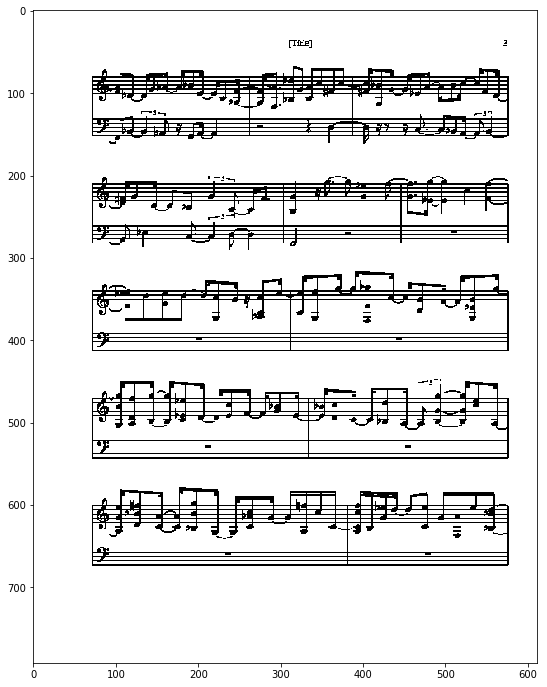

In [9]:
I = importImage(test_png)
showImage(I)

In [10]:
def rotateToHorizontal(img, lb=-.5, ub=.5, incr=.02, topN=40):
    bestscore = -np.inf
    bestTheta = 0
    for theta in np.arange(lb, ub, incr):
        imgRot = rotate(img,theta)
        rsums = np.sum(imgRot, axis=1)
        rsums_sorted = sorted(rsums)[::-1]
        curscore = np.sum(rsums_sorted[0:topN])
        if curscore > bestscore:
            bestscore = curscore
            bestTheta = theta
    result = rotate(img,bestTheta)
    return result, bestTheta

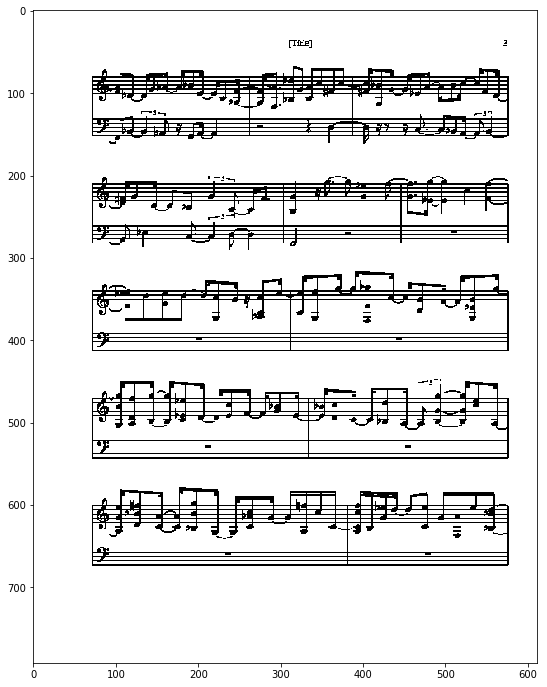

In [11]:
Irot, theta = rotateToHorizontal(I)
showImage(Irot)

In [12]:
def getBoundingBox(img, thresh=.01, buff=0.05):
    r = img.shape[0]
    c = img.shape[1]
    
    cmeans = np.mean(img, axis=0)
    cmean_thresh = np.max(cmeans) * thresh
    cidxs_above = np.argwhere(cmeans > cmean_thresh)
    col_start = cidxs_above[0][0]
    col_end = cidxs_above[-1][0]
    
    rmeans = np.mean(img, axis=1)
    rmean_thresh = np.max(rmeans) * thresh
    ridxs_above = np.argwhere(rmeans > rmean_thresh)
    row_start = ridxs_above[0][0]
    row_end = ridxs_above[-1][0]
    
    # add buffer to ignore clefs
    bufflen = np.int((col_end - col_start) * buff)
    col_start_adj = col_start + bufflen
    
    return (row_start, col_start_adj), col_end - col_start_adj, row_end - row_start

In [13]:
def showImageWithBB(X, loc, w, h, sz=(12,12)):
    fig = plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray')
    ax = fig.gca()
    rect = patches.Rectangle((loc[1],loc[0]), w, h, linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [14]:
def getCropped(X):
    ll, w, h = getBoundingBox(X)
    return X[ll[0]:ll[0]+h,ll[1]:ll[1]+w]

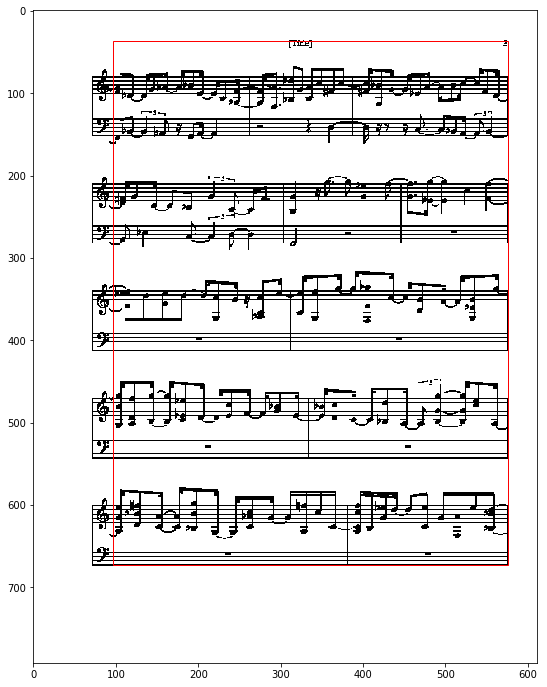

In [15]:
ll, bbw, bbh = getBoundingBox(Irot)
showImageWithBB(Irot, ll, bbw, bbh)

In [39]:
def getStripBoundaries(X, showPlot = False):
    # find staves
    filt = np.vstack((np.ones(21),np.zeros(21),-1*np.ones(21))) # emphasize horizontal lines
    Xfilt = signal.convolve2d(X-np.mean(X), filt, mode='same')
    rsum = np.sum(Xfilt, axis=1)
    rsum_spectra = librosa.core.stft(rsum,n_fft=32,hop_length=1) # look for high frequency oscillations
    spectra_max = np.max(rsum_spectra[4:10,:], axis=0)
    spectra_max_smoothed = np.convolve(spectra_max,np.hanning(15),'same')
    peakidxs = signal.find_peaks_cwt(spectra_max_smoothed, range(15,41,1))
    #assert(len(peakidxs) % 2 == 0)
    
    # determine boundaries
    numStrips = np.int(len(peakidxs)/2) - 1 
    boundaries = []
    for i in range(numStrips):
        peak1idx = peakidxs[2*i + 1]
        peak2idx = peakidxs[2*i + 2]
        midpt = np.int((peak1idx + peak2idx)/2.0)
        boundaries.append(midpt)
    boundaries.insert(0, 0)  # for first strip
    boundaries.append(X.shape[0]-1) # for last strip
    
    # show peak picking results (for debugging)
    if showPlot:
        plt.plot(spectra_max_smoothed)
        for pk in peakidxs:
            plt.axvline(x=pk, color='r', linewidth=1)
            
    return boundaries

In [17]:
def visualizeBoundaries(X, bnds, savefile = None):
    showImage(X)
    for bnd in bnds:
        plt.axhline(y=bnd, color='r', linewidth=1)
    if savefile:
        plt.savefig(savefile)

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


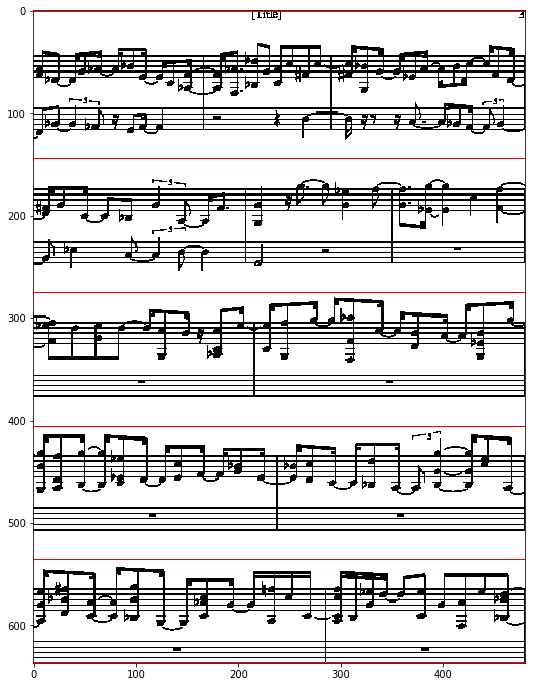

In [18]:
Icrop = getCropped(Irot)
bnds = getStripBoundaries(Icrop)
visualizeBoundaries(Icrop, bnds)

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app
/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')
/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


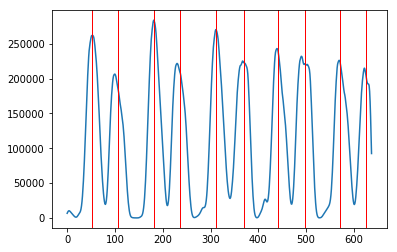

In [19]:
pngfile = test_png
I = importImage(pngfile)
Irot, theta = rotateToHorizontal(I)
ll, bbw, bbh = getBoundingBox(Irot)
Icrop = getCropped(Irot)
bnds = getStripBoundaries(Icrop, True)
plt.show()

In [31]:
def getStrips(X, bnds):
    strips = []
    for i in range(len(bnds)-1):
        rstart = bnds[i]
        rend = bnds[i+1] + 1 # include endpoint
        chunk = X[rstart:rend,:]
        strips.append(chunk)
    return strips

In [21]:
def showStrips(strips):
    for strip in strips:
        showImage(strip)

In [23]:
bnds

[0, 144, 274, 405, 535, 636]

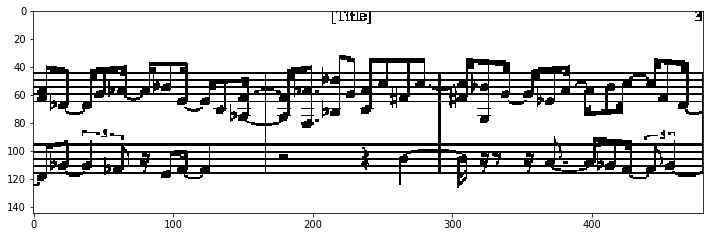

In [32]:
strips = getStrips(Icrop, bnds)
showImage(strips[0])

I'm gonna try to get spectra / peaks for just dis strip boi up here BUT FIRST I need to see what this stuff looks like.

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')
/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


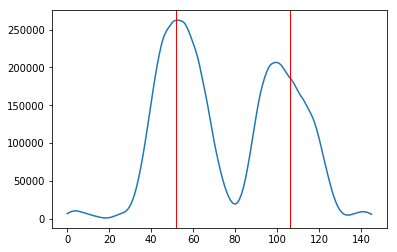

In [40]:
bnd_one_strip = getStripBoundaries(strips[0], True)

In [46]:
bnd_one_strip

[0, 144]

So it works for just one strip.  We wanna convert this sorta thing into note locations.

In [44]:
def saveOneResult(filename, outdir):
    # we don't have a bndsFile now so we'll have to figure out smth
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    #d = importBoundaryData(bndsFile)
        
    # get strip boundaries
    I = importImage(filename)
    Irot, theta = rotateToHorizontal(I)
    ll, w, h = getBoundingBox(Irot)
    Icrop = getCropped(Irot)
    basename = os.path.splitext(os.path.basename(filename))[0]
    bnds = getStripBoundaries(Icrop, True)
    strips = getStrips(Icrop, bnds)

    # save to file
    outfile = '%s/%s.pkl' % (outdir,basename)
    data = {}
    data['I'] = I
    data['theta'] = theta
    data['bb'] = (ll, w, h)
    data['Icrop'] = Icrop
    data['basename'] = basename
    data['bnds'] = bnds
    data['strips'] = strips
    with open(outfile, 'wb') as f:
        cPickle.dump(data, f)

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app
/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')
/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


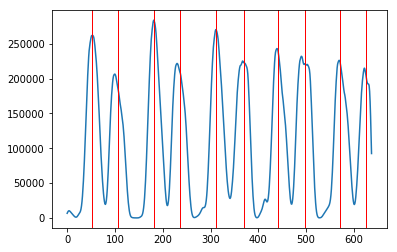

In [45]:
saveOneResult(pngfile, 'test_one_file', )

# Strip Analysis

In [56]:
def locateStaffLines(s, delta = 3, debug=False):
    medvals = np.median(s, axis=1)
    if debug:
        print("medvals are: " +  str(medvals))
    for i, curVal in enumerate(medvals):
        if i > delta and i < len(medvals)-delta:
            if curVal != np.max(medvals[i-delta:i+delta+1]): # only keep local maxima
                medvals[i] = 0
    idxs_sorted_val = np.argsort(medvals)[::-1]
    idxs_lines = sorted(idxs_sorted_val[0:10])
    if debug:
        print("sorted idxs val: " + str(idxs_sorted_val))
        print("idxs_lines: " + str(idxs_lines))
    return np.array(idxs_lines)

In [127]:
def estimateMidiNum2PixelRowMapping(s, lineIdxs, hand = 'right'):
    if hand == 'right':
        x = np.array([77, 74, 71, 67, 64]) # midi nums for staff lines
    elif hand == 'left':
        x = np.array([57, 53, 50, 47, 43])
    else:
        print('Unrecognized value for hand: %s' % hand)
        sys.exit(1)
    m, b, _, _, _ = linregress(x, lineIdxs)
    return (m,b)

In [49]:
def estimatePixelRow (midinum, m, b):
    return np.int(np.round(midinum * m + b))

Est location of C4

In [50]:
s = strips[0]
lines = locateStaffLines(s)
breakpt = np.int(np.round(.5*(lines[4]+lines[5])))
m, b = estimateMidiNum2PixelRowMapping(s[0:breakpt,:], lines[0:5], 'right')
estC4 = estimatePixelRow(60, m, b)

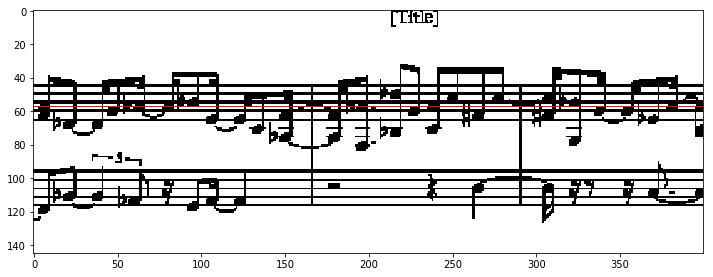

In [51]:
showImage(s[:,0:400])
plt.axhline(y = estC4, color='r', linewidth=1)
plt.show()

Let's see if we can est locations of bar lines and go from there. I'm going to experiment w different values of delta and see if anything happens.

LH seems alright but RH seems sort of messed up. We've missed the bottom two, in addition to the middle on the LH

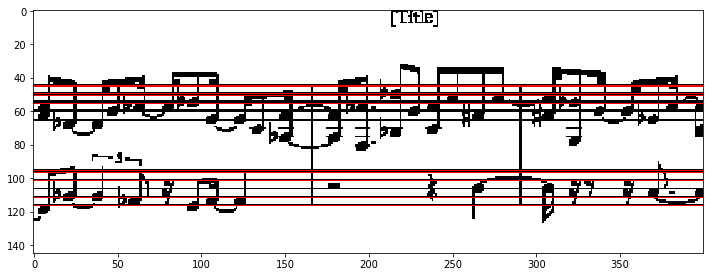

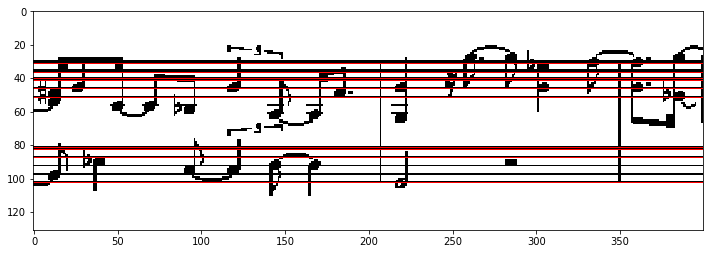

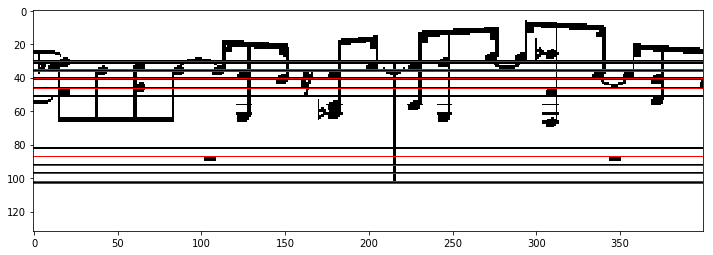

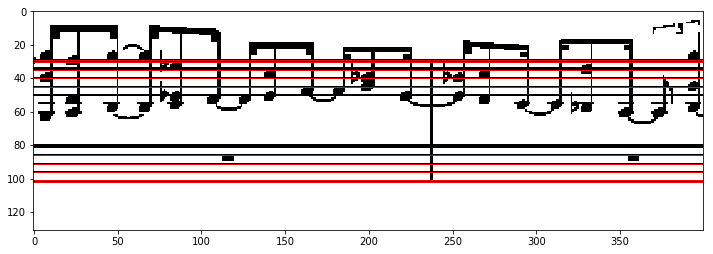

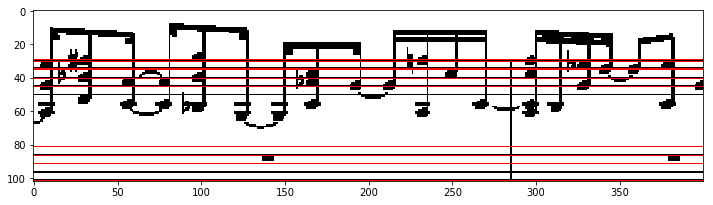

In [83]:
for strip in strips:
    lines = locateStaffLines(strip)
    showImage(strip[:, 0:400])
    for line in lines:
        plt.axhline(y=line, color='r', linewidth=1)
    plt.show()

Let's manually mess with one.

In [84]:
s = strips[0]
lines = locateStaffLines(s)

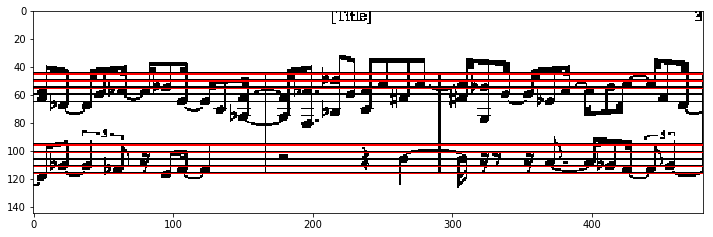

In [88]:
showImage(s)
for line in lines:
    plt.axhline(y=line, color='r', linewidth=1)
plt.show()

In [89]:
lines

array([ 44,  45,  49,  50,  55,  95,  96, 101, 111, 116])

In [92]:
linesCorrected = [44, 49, 54, 59, 64, 95, 101, 106, 111, 116]

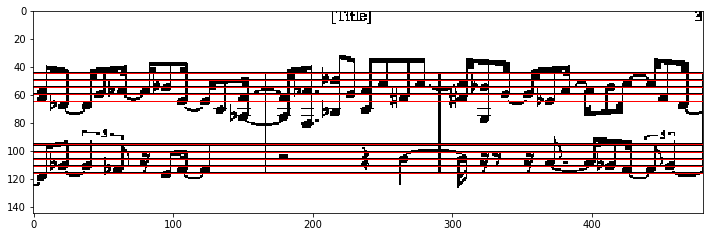

In [93]:
showImage(s)
for line in linesCorrected:
    plt.axhline(y=line, color='r', linewidth=1)
plt.show()

In [94]:
breakpt = np.int(np.round(.5*(linesCorrected[4]+linesCorrected[5])))
m, b = estimateMidiNum2PixelRowMapping(s[0:breakpt,:], linesCorrected[0:5], 'right')
estC4 = estimatePixelRow(60, m, b)

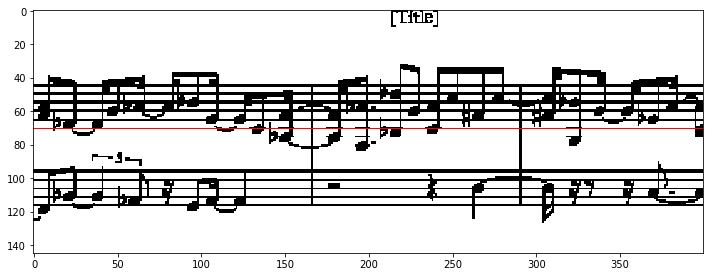

In [96]:
showImage(s[:, 0:400])
plt.axhline(y=estC4, color='r', linewidth=1)
plt.show()

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')
/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


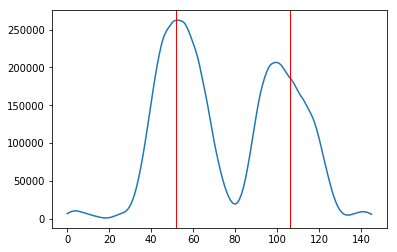

In [97]:
bnd_one_strip = getStripBoundaries(s, True)

Let's try to estimate D4 (MIDI val 62)

In [98]:
estD4 = estimatePixelRow(62, m, b)

In [108]:
estD4

67

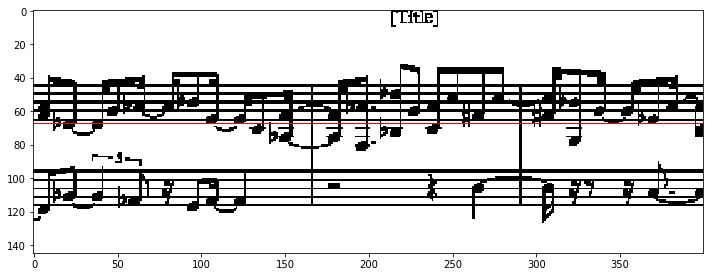

In [99]:
showImage(s[:, 0:400])
plt.axhline(y=estD4, color='r', linewidth=1)
plt.show()

# Create Note to Pixel Mapping

Here's our preliminary plan: We'll take this nice thing we have, grab pixel row estimates for all possible notes. Then we'll do linear interpolation on those values to get our fxn. Let's start with RH values (C4 and above). Let's just worry about going up to C6

In [102]:
note_vals = [i for i in range(60,85)] # will only go up to 84, which is C6

In [104]:
pixel_est = []

In [106]:
for note in note_vals:
    est = estimatePixelRow(note, m, b) # this is using the specific m,b for the thing we have
    pixel_est.append(est)

In [110]:
pixel_est

[70,
 69,
 67,
 65,
 64,
 62,
 61,
 59,
 58,
 56,
 55,
 53,
 52,
 50,
 49,
 47,
 46,
 44,
 43,
 41,
 40,
 38,
 37,
 35,
 34]

In [107]:
# define a fxn that interpolates and returns val of note from pixel location
def getNoteVal(pixel_row):
    return np.interp(pixel_row, pixel_est, note_vals)

In [109]:
getNoteVal(67)

84.0

# Just RH

Here, we'll take the RH part of the line above, grab the corrected line locations we created and then do the same thing over with this.

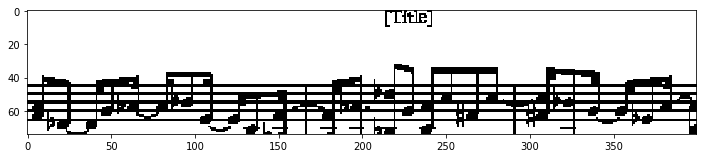

In [116]:
showImage(s[0:74, 0:400])

In [117]:
rightHand = s[0:74, :]

In [118]:
lines = locateStaffLines(rightHand)

In [120]:
rhLines = [44, 49, 54, 59, 64]

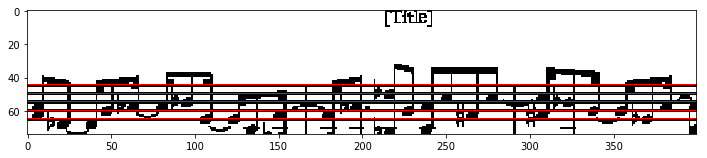

In [121]:
showImage(rightHand[:, 0:400])
for line in rhLines:
    plt.axhline(y=line, color='r', linewidth=1)
plt.show()

In [122]:
breakpt = np.int(np.round(.5*(rhLines[4]+rhLines[5])))
m, b = estimateMidiNum2PixelRowMapping(s[0:breakpt,:], rhLines[0:5], 'right')

IndexError: list index out of range

Ok we might have to mod the above to do smth with just the RH. We'll figure that out in a bit but let's use the old m,b for now.

In [123]:
estC4 = estimatePixelRow(60, m, b)

In [136]:
estD4

67

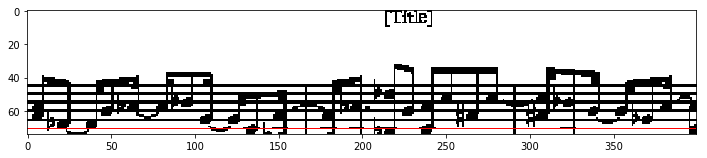

In [124]:
showImage(rightHand[:, 0:400])
plt.axhline(y=estC4, color='r', linewidth=1)
plt.show()

In [ ]:
note_vals = [i for i in range(60,85)] # will only go up to 84, which is C6

Let's see if we can define our own fxn to go from pixel 2 midi row num

In [126]:
def estimateMidiNum2PixelRowMapping2(s, lineIdxs, hand = 'right'):
    if hand == 'right':
        x = np.array([77, 74, 71, 67, 64]) # midi nums for staff lines
    elif hand == 'left':
        x = np.array([57, 53, 50, 47, 43])
    else:
        print('Unrecognized value for hand: %s' % hand)
        sys.exit(1)
    m, b, _, _, _ = linregress(lineIdxs, x) #I just switched lineIdxs and x here, let's see hao dis does boi
    return (m,b)

In [130]:
breakpt = np.int(np.round(.5*(linesCorrected[4]+linesCorrected[5])))
m, b = estimateMidiNum2PixelRowMapping2(s[0:breakpt,:], linesCorrected[0:5], 'right')

now we'll use m,b to get out a value (60 hopefully) from the pixel num (which will be 70)

In [134]:
def getNoteVal(pixelnum, m, b):
    return np.int(np.round(pixelnum * m + b))

In [137]:
getNoteVal(67,m,b)

62

It did it!